In [1]:
#import statements
import pandas as pd
import numpy as np
from pyspark.sql import HiveContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install --user seaborn
# !pip install --user --upgrade pip

spark = SparkSession.builder.appName('ReadData').getOrCreate()
sc = spark.sparkContext
hive_context = HiveContext(sc)

In [2]:
# dfzip = spark.read.format("csv").option("header", "true").load("./project/zipcode/zip_code_database.csv")

In [3]:
joined = hive_context.table("donor.final_projects_joined")
joined.dtypes

[('project_id', 'string'),
 ('school_id', 'string'),
 ('teacher_id', 'string'),
 ('project_seq', 'int'),
 ('project_type', 'string'),
 ('project_grad_level', 'string'),
 ('project_resource', 'string'),
 ('project_cost', 'float'),
 ('project_post_date', 'date'),
 ('project_exp_date', 'date'),
 ('project_status', 'string'),
 ('project_full_fund_date', 'date'),
 ('project_cat1', 'string'),
 ('project_cat2', 'string'),
 ('project_subcat1', 'string'),
 ('project_subcat2', 'string'),
 ('school_name', 'string'),
 ('school_metro_type', 'string'),
 ('school_percentage_free_lunch', 'float'),
 ('school_state', 'string'),
 ('school_zip', 'string'),
 ('school_city', 'string'),
 ('school_county', 'string'),
 ('school_district', 'string'),
 ('donation_amount_sum', 'double'),
 ('number_of_donations', 'bigint'),
 ('number_of_resources_needed', 'bigint'),
 ('resources_amount_sum', 'double'),
 ('resources_total_quantity', 'double'),
 ('teacher_prefix', 'string'),
 ('teacher_first_project_posted_date', 'd

In [4]:
donation_donor = hive_context.table("donor.donation_donor")

In [5]:
school = hive_context.table("donor.schools")
school = school.filter(school['school_id'] != 'School ID')

In [6]:
resources = hive_context.table("donor.resources")
resources = resources.filter(resources['project_id'] != 'Project ID')

In [7]:
project = hive_context.table("donor.projects")
project = project.filter(project['project_id'] != 'Project ID')

Count how many are teachers

In [8]:
eda1 = donation_donor.groupby('donor_id',"donor_is_teacher").count().groupby('donor_is_teacher').count()

In [9]:
eda1pd = eda1.toPandas()
eda1pd

,donor_is_teacher,count
0,No,1808723
1,Yes,210239


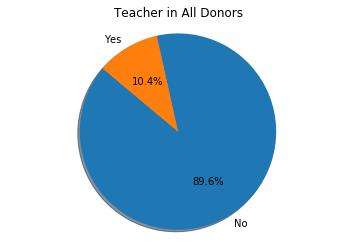

In [10]:
fig = plt.figure()
plt.pie(eda1pd['count'],labels = eda1pd['donor_is_teacher'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Teacher in All Donors')
fig.savefig('teacher_in_all.png')

In [11]:
eda1b = donation_donor.groupby('donor_id',"donor_is_teacher").count().withColumnRenamed("count", "num_times")

In [12]:
eda1c = eda1b.groupby('donor_is_teacher').agg(count('donor_id'), sum('num_times'))\
.withColumnRenamed("count(donor_id)", "count_all_donor").withColumnRenamed("sum(num_times)", "total_donation_times")

In [13]:
eda1cpd = eda1c.toPandas()
eda1cpd

,donor_is_teacher,count_all_donor,total_donation_times
0,No,1808723,3342679
1,Yes,210239,1339221


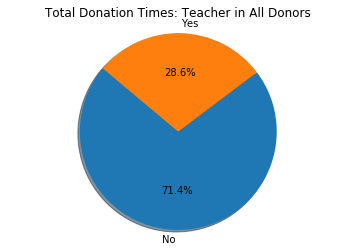

In [14]:
fig = plt.figure()
plt.pie(eda1cpd['total_donation_times'],labels = eda1cpd['donor_is_teacher'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Total Donation Times: Teacher in All Donors')
fig.savefig('doanation_times_teacher_in_all.png')

Count multi-time donors

In [15]:
eda2 = donation_donor.groupby('donor_id',"donor_is_teacher").count().filter('count > 1')
eda2 = eda2.withColumnRenamed("count", "num_times")

In [16]:
eda2a = eda2.groupby('donor_is_teacher').count().withColumnRenamed("count", "count_multi_times_donor")

In [17]:
eda2b = eda2.groupby('donor_is_teacher').agg(count('donor_id'), sum('num_times'))\
.withColumnRenamed("count(donor_id)", "count_multi_times_donor").withColumnRenamed("sum(num_times)", "total_donation_times")

In [18]:
eda2bpd = eda2b.toPandas()
eda2bpd

,donor_is_teacher,count_multi_times_donor,total_donation_times
0,No,419598,1953554
1,Yes,133074,1262056


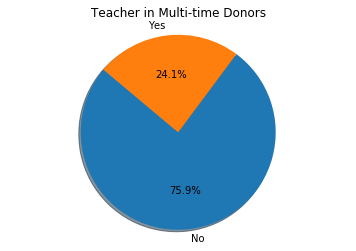

In [19]:
fig = plt.figure()
plt.pie(eda2bpd['count_multi_times_donor'],labels = eda2bpd['donor_is_teacher'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Teacher in Multi-time Donors')
fig.savefig('teacher_in_multi.png')

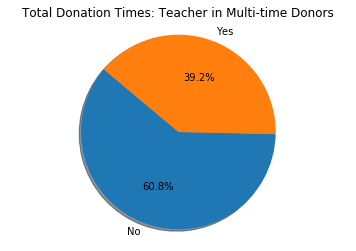

In [20]:
fig = plt.figure()
plt.pie(eda2bpd['total_donation_times'],labels = eda2bpd['donor_is_teacher'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Total Donation Times: Teacher in Multi-time Donors')
fig.savefig('doanation_times_teacher_in_multi.png')

Donation amount if teacher

In [21]:
# eda3 = donation_donor.groupby('donor_id',"donor_is_teacher",'donation_amount')\
#     .agg({"donation_amount":"sum",'donor_id':'count'})\
#     .withColumnRenamed("count(donor_id)", "num_times")\
#     .withColumnRenamed("sum(donation_amount)", "total_donation_amount")
# eda3a = eda3.groupby("donor_is_teacher").agg({"total_donation_amount":"sum","donor_id":"count"})

donor by state

In [22]:
eda4 = donation_donor.groupby('donor_id','donor_state').count().withColumnRenamed("count", "num_times")
# .agg({'donor_is_teacher' : 'count' }).sort('count(donor_is_teacher)',ascending =False)
# eda4.show()

In [23]:
eda5 = eda4.groupby('donor_state').count().sort('count',ascending =False)
eda5pd = eda5.toPandas()
eda5pd.head()

,donor_state,count
0,California,283393
1,New York,131839
2,Texas,127237
3,Florida,103978
4,other,103334


<Figure size 432x288 with 0 Axes>

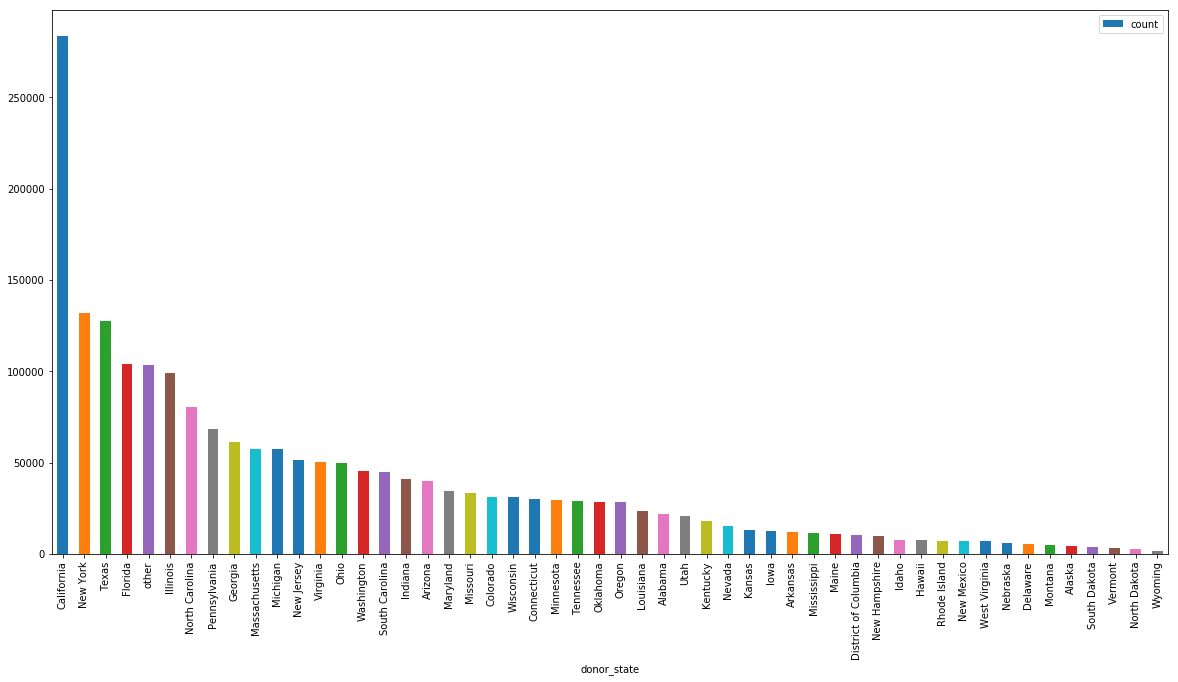

In [24]:
plt.figure()
eda5pd.plot.bar(x='donor_state', y='count',figsize=(20, 10))
plt.savefig('number_donor_by_state.png')

School table - school metro type

In [25]:
eda6 = school.groupby('school_metro_type').count().sort('count',ascending =False)

<Figure size 432x288 with 0 Axes>

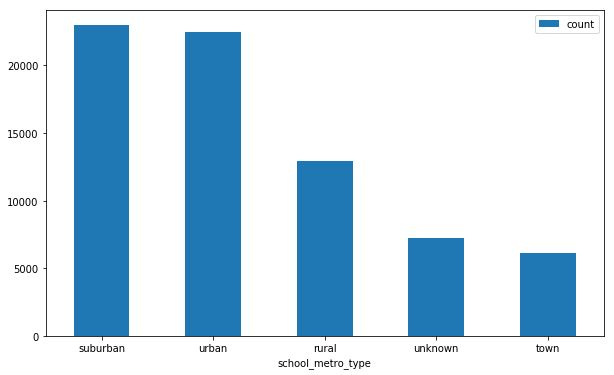

In [26]:
eda6pd = eda6.toPandas()
plt.figure()
eda6pd.plot.bar(x='school_metro_type',figsize=(10, 6),rot=0)
plt.savefig('school_metro_type.png')

Project table - project_cost vs school type

In [27]:
eda7 = project.groupBy('project_type').agg({'project_cost':'avg'})
# .agg({'project_type':'count','project_cost':'sum'})
eda7pd = eda7.toPandas()

<Figure size 432x288 with 0 Axes>

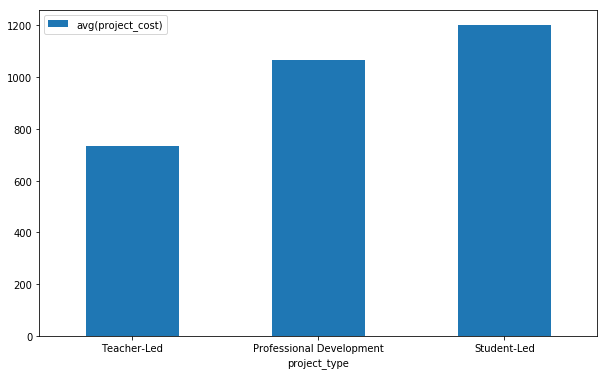

In [28]:
plt.figure()
eda7pd.plot.bar(x='project_type',figsize=(10, 6),rot=0)
plt.savefig('average cost on project type.png')

resources -  top vendor

In [29]:
eda8 = resources.groupby('resource_vendor_name').count().sort('count',ascending =False)

In [30]:
eda8pd = eda8.limit(10).toPandas()
eda8pd

,resource_vendor_name,count
0,Amazon Business,3203169
1,Lakeshore Learning Materials,1080820
2,AKJ Education,964490
3,Best Buy Education,315762
4,School Specialty,240064
5,Quill.com,222896
6,Kaplan Early Learning Company,194288
7,Blick Art Materials,166818
8,Staples Advantage,163323
9,Nasco,126483


<Figure size 432x288 with 0 Axes>

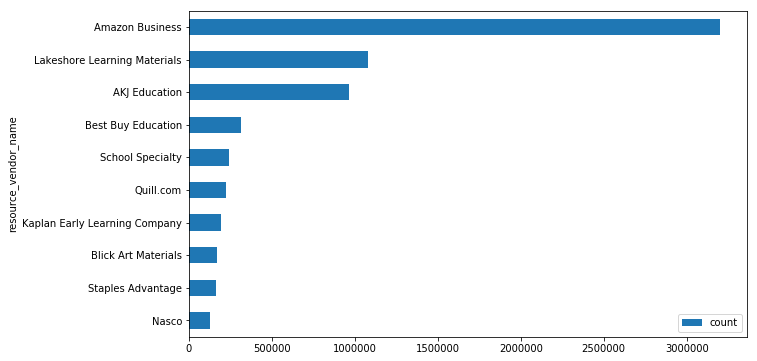

In [31]:
plt.figure()
eda8pd.plot.barh(x='resource_vendor_name',figsize=(10, 6))
plt.gca().invert_yaxis()
plt.savefig('top 10 vendors.png')

Project status vs avg cost

In [32]:
eda9 = spark.sql(
'''select project_status, project_cost from donor.final_projects_joined''')
eda9pd = eda9.toPandas()

In [33]:
eda9pd['project_cost'] = eda9pd['project_cost']
# .astype(float)
eda9pd.head(5)

,project_status,project_cost
0,Fully Funded,698.150024
1,Fully Funded,294.950012
2,Fully Funded,411.420013
3,Fully Funded,424.450012
4,Fully Funded,744.530029


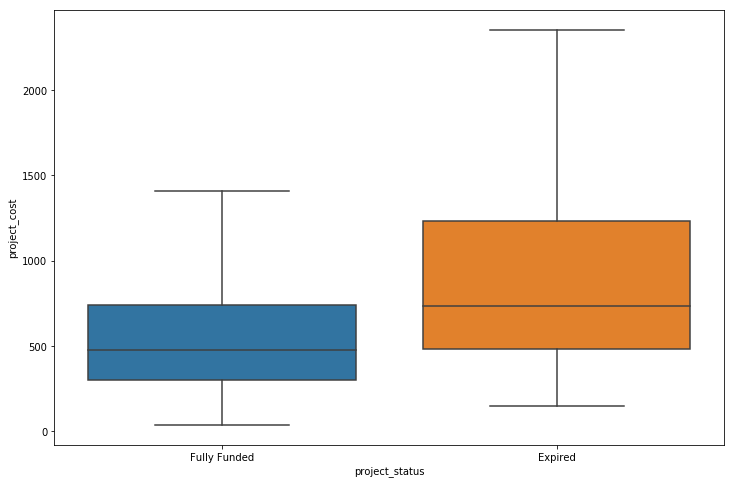

In [34]:
plt.figure(figsize=(12,8))
sns.boxplot(x="project_status", y="project_cost", data= eda9pd, showfliers=False)
plt.savefig('project_status_cost.png')

Project status vs month

In [35]:
eda10 = spark.sql(
'''select project_status, month_of_post_date, count(*) as count from donor.final_projects_joined
group by month_of_post_date, project_status order by month_of_post_date
''')

In [36]:
eda10pd = eda10.toPandas()
eda10pd['count'] = eda10pd['count'].astype(float)
eda10pd.head()

,project_status,month_of_post_date,count
0,Expired,1,15151.0
1,Fully Funded,1,77798.0
2,Fully Funded,2,68547.0
3,Expired,2,13415.0
4,Fully Funded,3,80644.0


In [37]:
# eda10pd.groupby(['month_of_post_date','project_status'])['count'].transform(lambda x: x/x.sum())
df = eda10pd.pivot_table(index = "month_of_post_date",columns='project_status',values='count')
df

project_status,Expired,Fully Funded
month_of_post_date,,
1,15151.0,77798.0
2,13415.0,68547.0
3,20936.0,80644.0
4,13797.0,47904.0
5,15321.0,36544.0
6,14818.0,33305.0
7,18568.0,47575.0
8,32874.0,102424.0
9,35543.0,117513.0


<Figure size 864x576 with 0 Axes>

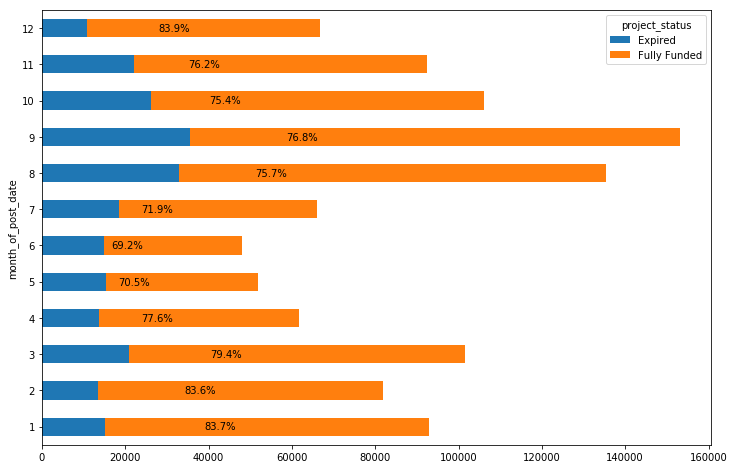

In [38]:
# sns.barplot(x="month_of_post_date", y="count", hue='project_status', data= eda10pd)
# eda10pd.pivot("month_of_post_date",'project_status','count').plot(kind = 'bar', stacked = True)

plt.figure(figsize=(12,8))
df.plot(kind='barh',stacked = True, mark_right = True,figsize=(12,8))
df_total = df.sum(axis=1)
df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
#         plt.text(tot, i, str(tot), va='center')
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='left')
plt.savefig('project_status_month.png')

In [39]:
eda11 = joined.groupby('project_status').count().toPandas()

In [40]:
eda11

,project_status,count
0,Fully Funded,818694
1,Expired,239258


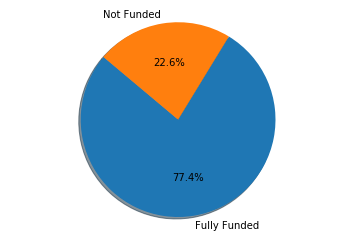

In [41]:
fig = plt.figure()
plt.pie(eda11['count'],labels = ['Fully Funded','Not Funded'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.savefig('project_status.png')

In [42]:
joined.dtypes

[('project_id', 'string'),
 ('school_id', 'string'),
 ('teacher_id', 'string'),
 ('project_seq', 'int'),
 ('project_type', 'string'),
 ('project_grad_level', 'string'),
 ('project_resource', 'string'),
 ('project_cost', 'float'),
 ('project_post_date', 'date'),
 ('project_exp_date', 'date'),
 ('project_status', 'string'),
 ('project_full_fund_date', 'date'),
 ('project_cat1', 'string'),
 ('project_cat2', 'string'),
 ('project_subcat1', 'string'),
 ('project_subcat2', 'string'),
 ('school_name', 'string'),
 ('school_metro_type', 'string'),
 ('school_percentage_free_lunch', 'float'),
 ('school_state', 'string'),
 ('school_zip', 'string'),
 ('school_city', 'string'),
 ('school_county', 'string'),
 ('school_district', 'string'),
 ('donation_amount_sum', 'double'),
 ('number_of_donations', 'bigint'),
 ('number_of_resources_needed', 'bigint'),
 ('resources_amount_sum', 'double'),
 ('resources_total_quantity', 'double'),
 ('teacher_prefix', 'string'),
 ('teacher_first_project_posted_date', 'd

In [43]:
eda12 = spark.sql(
'''select project_status, school_metro_type, count(*) as count from donor.final_projects_joined
group by school_metro_type, project_status
''')

In [44]:
eda12pd = eda12.toPandas()
eda12pd['count'] = eda12pd['count'].astype(float)
eda12pd.head()

,project_status,school_metro_type,count
0,Expired,town,13006.0
1,Fully Funded,suburban,244332.0
2,Fully Funded,urban,393906.0
3,Expired,rural,27666.0
4,Fully Funded,rural,79180.0


In [45]:
df = eda12pd.pivot_table(index = "school_metro_type",columns='project_status',values='count')
df

project_status,Expired,Fully Funded
school_metro_type,,
rural,27666.0,79180.0
suburban,78770.0,244332.0
town,13006.0,35936.0
unknown,20371.0,65340.0
urban,99445.0,393906.0


<Figure size 432x288 with 0 Axes>

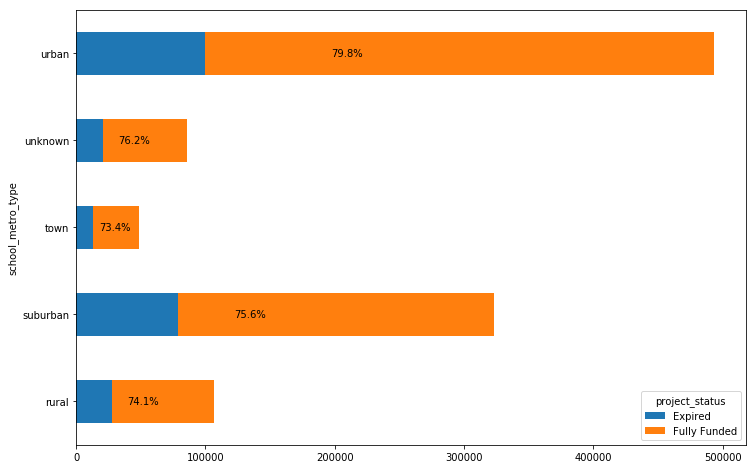

In [46]:
plt.figure()
df.plot(kind='barh',stacked = True, mark_right = True,figsize=(12,8))
df_total = df.sum(axis=1)
df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='left')
plt.savefig('project_status_metro.png')

In [47]:
eda13 = spark.sql(
'''select project_status, project_cat1, count(*) as count from donor.final_projects_joined
group by project_cat1, project_status
''')
edapd = eda13.toPandas()
edapd['count'] = edapd['count'].astype(float)
# edapd.head()
df = edapd.pivot_table(index = "project_cat1",columns='project_status',values='count')
df

project_status,Expired,Fully Funded
project_cat1,,
Applied Learning,27902.0,94412.0
Health & Sports,13003.0,52718.0
History & Civics,11048.0,38798.0
Literacy & Language,112185.0,354080.0
Math & Science,53857.0,196106.0
Music & The Arts,12239.0,44676.0
Special Needs,8526.0,28646.0
Warmth,498.0,9258.0


<Figure size 432x288 with 0 Axes>

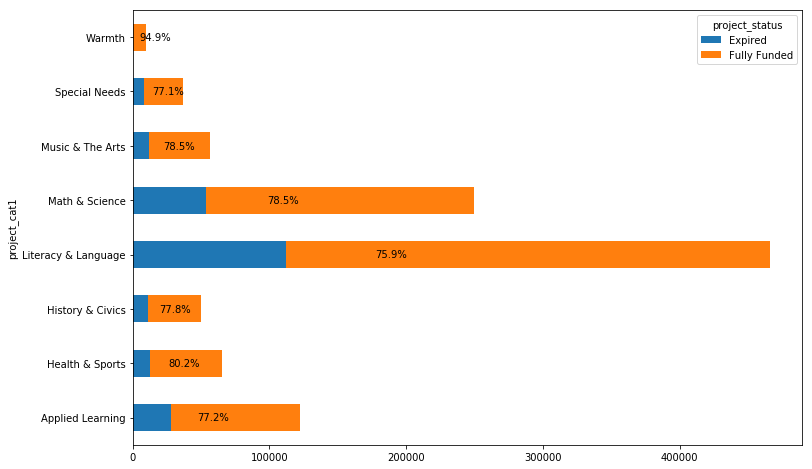

In [48]:
plt.figure()
df.plot(kind='barh',stacked = True, mark_right = True,figsize=(12,8))
df_total = df.sum(axis=1)
df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='left')
plt.savefig('project_status_cat1.png')

In [49]:
eda14 = spark.sql(
'''select project_status, teacher_prefix, count(*) as count from donor.final_projects_joined
group by teacher_prefix, project_status
''')
edapd = eda14.toPandas()
edapd = edapd.loc[edapd['teacher_prefix'] != 'Mx.']
edapd = edapd.loc[edapd['teacher_prefix'] != 'Dr.']
edapd['count'] = edapd['count'].astype(float)
# edapd.head()
df = edapd.pivot_table(index = "teacher_prefix",columns='project_status',values='count')
df

project_status,Expired,Fully Funded
teacher_prefix,,
Mr.,25691.0,89919.0
Mrs.,130244.0,413831.0
Ms.,79426.0,304352.0
Teacher,3848.0,10312.0


In [50]:
edapd

,project_status,teacher_prefix,count
0,Expired,Teacher,3848.0
2,Fully Funded,Teacher,10312.0
3,Fully Funded,Ms.,304352.0
5,Expired,Mrs.,130244.0
7,Expired,Ms.,79426.0
9,Fully Funded,Mrs.,413831.0
10,Expired,Mr.,25691.0
11,Fully Funded,Mr.,89919.0


<Figure size 432x288 with 0 Axes>

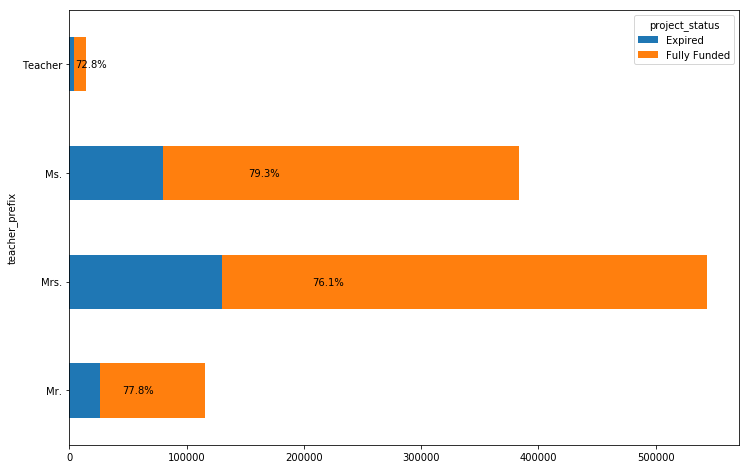

In [51]:
plt.figure()
df.plot(kind='barh',stacked = True, mark_right = True,figsize=(12,8))
df_total = df.sum(axis=1)
df_rel = df[df.columns[1:]].div(df_total, 0)*100

for n in df_rel:
    for i, (cs, ab, pc, tot) in enumerate(zip(df.iloc[:, 1:].cumsum(1)[n], df[n], df_rel[n], df_total)):
        plt.text(cs - ab/2, i, str(np.round(pc, 1)) + '%', va='center', ha='left')
plt.savefig('project_status_prefix.png')